In [122]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [123]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

In [124]:
NUM_CLASSES = 7

In [125]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [126]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [128]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [129]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_14 (Dropout)        (None, 42)                0         
                                                                 
 dense_21 (Dense)            (None, 20)                860       
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_22 (Dense)            (None, 10)                210       
                                                                 
 dense_23 (Dense)            (None, 7)                 77        
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________


In [130]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [131]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [132]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/40 [..............................] - ETA: 29s - loss: 2.4275 - accuracy: 0.0859
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 1s 6ms/step - loss: 2.1194 - accuracy: 0.1076 - val_loss: 1.9085 - val_accuracy: 0.2313
Epoch 2/1000
39/40 [============================>.] - ETA: 0s - loss: 1.9267 - accuracy: 0.1953
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 0s 3ms/step - loss: 1.9259 - accuracy: 0.1962 - val_loss: 1.8383 - val_accuracy: 0.3648
Epoch 3/1000
 1/40 [..............................] - ETA: 0s - loss: 1.8549 - accuracy: 0.2734
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 0s 2ms/step - loss: 1.8415 - accuracy: 0.2640 - val_loss: 1.7642 - val_accuracy: 0.3814
Epoch 4/1000
 1/40 [..............................] - ETA: 0s - loss: 1.8395 - accuracy: 0.2188


In [133]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 1ms/step - loss: 0.3180 - accuracy: 0.9158


In [134]:
model = tf.keras.models.load_model(model_save_path)

In [135]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 63ms/step
[9.0813565e-01 8.8247888e-02 1.3928968e-03 1.9682804e-03 2.4408788e-08
 2.5543384e-04 2.4366620e-10]
0


53/53 [==============================] - 0s 718us/step


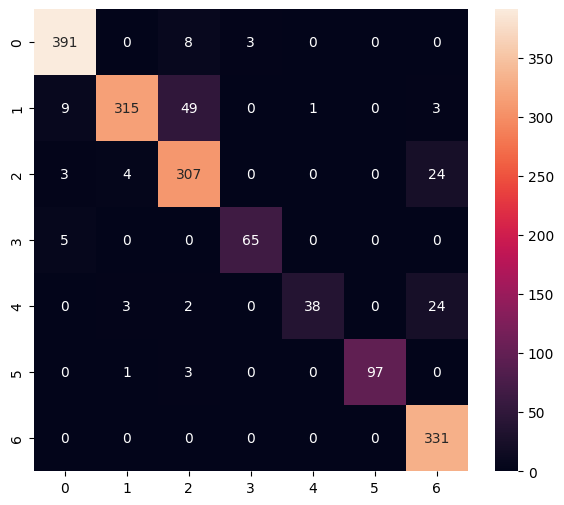

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       402
           1       0.98      0.84      0.90       377
           2       0.83      0.91      0.87       338
           3       0.96      0.93      0.94        70
           4       0.97      0.57      0.72        67
           5       1.00      0.96      0.98       101
           6       0.87      1.00      0.93       331

    accuracy                           0.92      1686
   macro avg       0.94      0.88      0.90      1686
weighted avg       0.92      0.92      0.91      1686



In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [137]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [138]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2024-04-24 14:26:29.017952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_8' with dtype float and shape [?,42]
	 [[{{node input_8}}]]
2024-04-24 14:26:29.096176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2024-04-24 14:26:29.111889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_8' with dtype float and shape [?,42]
	 [[{{node input_8}}]]
2024-04-24 14:2

INFO:tensorflow:Assets written to: /var/folders/19/m0bcjj711qb24qc69_l251wm0000gn/T/tmp4g6_dsbd/assets


INFO:tensorflow:Assets written to: /var/folders/19/m0bcjj711qb24qc69_l251wm0000gn/T/tmp4g6_dsbd/assets
2024-04-24 14:26:32.331599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-04-24 14:26:32.331623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-04-24 14:26:32.331929: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/19/m0bcjj711qb24qc69_l251wm0000gn/T/tmp4g6_dsbd
2024-04-24 14:26:32.333890: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-24 14:26:32.333906: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/19/m0bcjj711qb24qc69_l251wm0000gn/T/tmp4g6_dsbd
2024-04-24 14:26:32.342963: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-04-24 14:26:32.401973: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

6740

In [139]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [140]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [141]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [142]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 302 µs, sys: 95 µs, total: 397 µs
Wall time: 391 µs


In [143]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.0813547e-01 8.8247940e-02 1.3928992e-03 1.9682799e-03 2.4408783e-08
 2.5543376e-04 2.4366567e-10]
0
